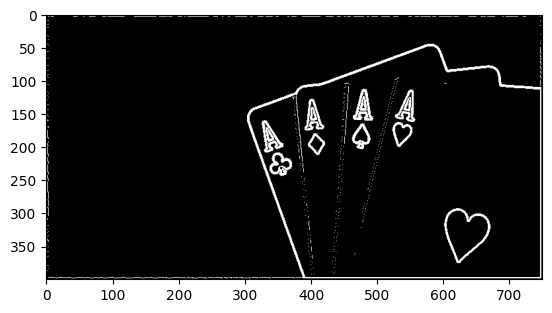

In [14]:
# importacion de las librerias
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# 1. Suavizar la imagen para eliminar el ruido

# para esto se aplica un filtro gausssiano de 5x5
foto = '119.jpg'
# se carga la imagen
imag = cv2.imread(foto,0)   # se lee la imagen en BGR
#imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)   # convierte la imagen a RGB
plt.imshow(imag,cmap="gray")   # muestra la imagen
filas, columnas = imag.shape

matImg = np.array(imag)

gauss = np.array([[2, 4, 5, 4, 2],
                  [4, 9, 12, 9, 4],
                  [5, 12, 15, 12, 5],
                  [4, 9, 12, 9, 4],
                  [2, 4, 5, 4, 2]])


# se realiza el proceso de convolucion
def convolucion(matriz_imagen, kernel):
     convolucion = np.zeros((filas, columnas))

     for x in range(filas):
          for y in range(columnas):
               for x2 in range(len(kernel)):
                    for y2 in range(len(kernel[0])):
                         if(len(kernel[0]) == 5):
                              if(x>2 and x<filas-2 and y>2 and y<columnas-2):
                                   convolucion[x,y] += (kernel[x2,y2] * matriz_imagen[x-2+x2,y-2+y2])
                         if(len(kernel[0]) == 3):     
                              if(x>1 and x<filas-1 and y>1 and y<columnas-1):
                                   convolucion[x,y] += (kernel[x2,y2] * matriz_imagen[x-1+x2,y-1+y2])
     return convolucion

matGauss = convolucion(imag, gauss)
matGauss = cv2.normalize(matGauss, None, 0, 255, cv2.NORM_MINMAX)

# Crea una imagen RGB desde la matriz tridimensional
imgGauss= Image.fromarray(matGauss)
plt.imshow(imgGauss,cmap="gray")

# 2. Encontrar gradientes de la imagen para detectar los bordes
matGauss = np.float64(matGauss)

sobelX = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])

matSobelX = convolucion(matGauss, sobelX)
#matSobelX = unionCanales(rojoSX,verdeSX,azulSX,1)
imgSobelX = Image.fromarray(matSobelX)
plt.imshow(imgSobelX)

sobelY = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])
matSobelY = convolucion(matGauss, sobelY)
#matSobelY = unionCanales(rojoSY,verdeSY,azulSY,1)
imgSobelY = Image.fromarray(matSobelY)
plt.imshow(imgSobelY)

def magnitudGradiente(derivadaX, derivadaY):
    gm = (derivadaX ** 2 + derivadaY ** 2) ** 0.5
    return gm

def direccionGradiente(derivadaX, derivadaY):
    gd = np.rad2deg(np.arctan2(derivadaY, derivadaX))
    return gd

matGm = magnitudGradiente(matSobelX,matSobelY)
matGd = magnitudGradiente(matSobelX,matSobelY)

imgGm = Image.fromarray(matGm)
plt.imshow(imgGm)

imgGd = Image.fromarray(matGd)
plt.imshow(imgGd)

# Paso 3. No supresion maxima

def NoSupresionMazima(Gm, Gd):
    Gd_bins = 45 * (np.round(Gd / 45))

    NSM = np.zeros((filas, columnas))

    for r in range(1, filas - 1):
        for c in range(1, columnas - 1):
            angulo = Gd_bins[r, c]

            vecino_a, vecino_b = 0., 0.

            if angulo == 0.:
                vecino_a, vecino_b = Gm[r, c - 1], Gm[r, c + 1]
            elif angulo == 45.:
                vecino_a, vecino_b = Gm[r - 1, c - 1], Gm[r + 1, c + 1]
            elif angulo == 90.:
                vecino_a, vecino_b = Gm[r - 1, c], Gm[r + 1, c]
            elif angulo == 135.:
                vecino_a, vecino_b = Gm[r - 1, c + 1], Gm[r + 1, c - 1]

            if Gm[r, c] >= vecino_a and Gm[r, c] >= vecino_b:
                NSM[r, c] = Gm[r, c]

    return NSM

matNSM = NoSupresionMazima(matGm,matGd)

imgNSM = Image.fromarray(matNSM)
plt.imshow(imgNSM)

# Paso 4. Umbralizacion con histeresis

def UmbralizacionHisteresis(HSM):
    
     # mbrales inferior y superior
     umbral_inferior = 25
     umbral_superior = 70

     # Crear una matriz de ceros del mismo tamaño que la imagen
     histeresis = np.zeros((filas,columnas))

     # Aplicar umbralización con histéresis
     for i in range(filas):
          for j in range(columnas):
               if HSM[i, j] > umbral_superior:
                    histeresis[i, j] = 255  # borde Fuerte
               elif HSM[i, j] > umbral_inferior:
                    for x in range(-1, 2):
                         for y in range(-1, 2):
                              if HSM[i + x, j + y] > umbral_superior:
                                   histeresis[i, j] = 255  # borde debil
                              break

     return histeresis

# Visualizar los bordes detectados
matHisteresis = UmbralizacionHisteresis(matNSM)

imgHisteresis = Image.fromarray(matHisteresis)
plt.imshow(imgHisteresis)

In [ ]:
def recorrido(imagen):
    for i in range(filas):
         for j in range(columnas):
              if(imagen[i, j]==0):
                   